In [29]:
import pandas as pd
from xgboost import XGBClassifier
from sklearn.metrics import classification_report
from sentence_transformers import SentenceTransformer
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import precision_recall_curve, average_precision_score

In [30]:
class HateSpeechXGBClassifier:
    def __init__(self, threshold: float = 0.75, n_estimators: int = 100, max_depth: int = 6, learning_rate: float = 0.3):
        self.threshold = threshold
        self.encoder = SentenceTransformer("all-MiniLM-L6-v2")
        self.model = XGBClassifier(
            n_estimators=n_estimators,
            max_depth=max_depth,
            learning_rate=learning_rate,
            random_state=42,
            eval_metric='logloss'
        )

    def embed(self, texts: pd.Series) -> np.ndarray:
        return self.encoder.encode(texts.tolist(), show_progress_bar=False)

    def train(self, X: pd.Series, y: pd.Series) -> None:
        X_embed = self.embed(X)
        self.model.fit(X_embed, y)

    def predict_proba(self, X: pd.Series) -> pd.Series:
        X_embed = self.embed(X)
        proba = self.model.predict_proba(X_embed)[:, 1]
        return pd.Series(proba, index=X.index)

    def predict(self, X: pd.Series) -> pd.Series:
        proba = self.predict_proba(X)
        return (proba > self.threshold).astype(int)

    def evaluate(self, X_test: pd.Series, y_test: pd.Series) -> None:
        y_pred = self.predict(X_test)
        print(classification_report(y_test, y_pred))

    def plot_confusion_matrix(self, y_true, y_pred):
        cm = confusion_matrix(y_true, y_pred)
        sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Not Hate", "Hate"], yticklabels=["Not Hate", "Hate"])
        plt.xlabel("Predicted")
        plt.ylabel("Actual")
        plt.title("Confusion Matrix")
        plt.show()

    def show_misclassifications(self, X: pd.Series, y_true: pd.Series, y_pred: pd.Series):
        mismatches = X[(y_true != y_pred)]
        print("\nFALSE POSITIVES:")
        print(mismatches[(y_true == 0) & (y_pred == 1)].head(5).to_string(index=False))

        print("\nFALSE NEGATIVES:")
        print(mismatches[(y_true == 1) & (y_pred == 0)].head(5).to_string(index=False))


In [31]:
def main():
    train_df = pd.read_csv("../data/train_data.csv")
    test_df = pd.read_csv("../data/test_data_clean.csv")

    model = HateSpeechXGBClassifier(
        threshold=0.25, 
        n_estimators=100,
        max_depth=6,
        learning_rate=0.3
    )

    X_train = train_df["text"]
    y_train = train_df["label"]
    
    X_test = test_df["comment"]
    y_test = test_df["isHate"]

    model.train(X_train, y_train)
    
    model.evaluate(X_test, y_test)

    test_probs = model.predict_proba(X_test)
    test_preds = model.predict(X_test)

    plt.figure(figsize=(10, 5))
    
    model.plot_confusion_matrix(y_test, test_preds)

    plt.figure(figsize=(8, 6))
    fpr_test, tpr_test, _ = roc_curve(y_test, test_probs)
    roc_auc_test = auc(fpr_test, tpr_test)
    plt.plot(fpr_test, tpr_test, label=f"ROC curve (AUC = {roc_auc_test:.2f})", linewidth=2)
    plt.plot([0, 1], [0, 1], linestyle="--", color="gray")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("ROC Curve - Test Data")
    plt.legend(loc="lower right")
    plt.grid(True)
    plt.show()
    
    precision, recall, thresholds = precision_recall_curve(y_test, test_probs)
    avg_prec = average_precision_score(y_test, test_probs)


    plt.figure(figsize=(8, 6))
    plt.plot(recall, precision, label=f"PR curve (AP = {avg_prec:.2f})", linewidth=2)
    plt.xlabel("Recall")
    plt.ylabel("Precision")
    plt.title("Precision-Recall Curve - Test Data")
    plt.legend(loc="lower left")
    plt.grid(True)
    plt.show()
    

              precision    recall  f1-score   support

           0       0.77      0.45      0.57       475
           1       0.64      0.88      0.74       523

    accuracy                           0.67       998
   macro avg       0.70      0.66      0.65       998
weighted avg       0.70      0.67      0.66       998



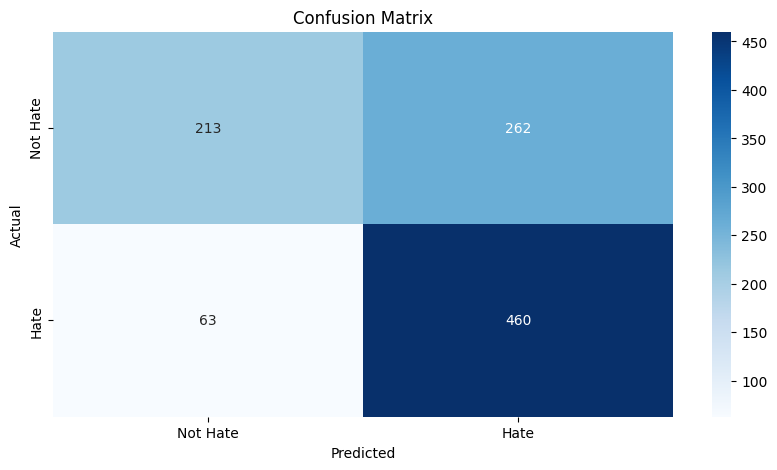

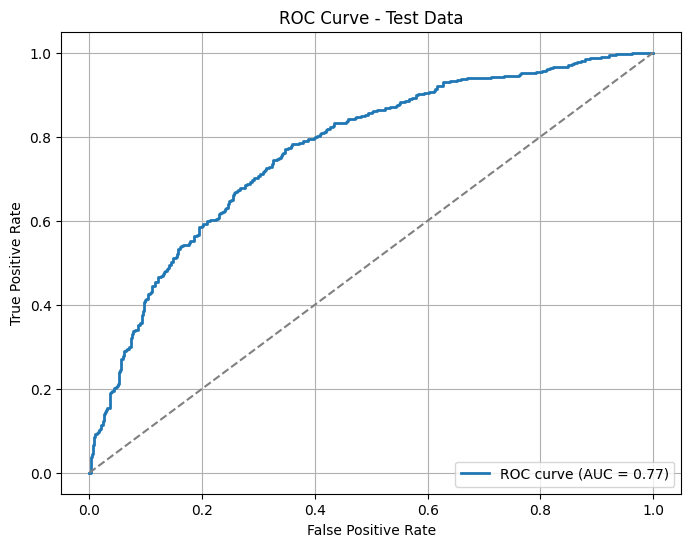

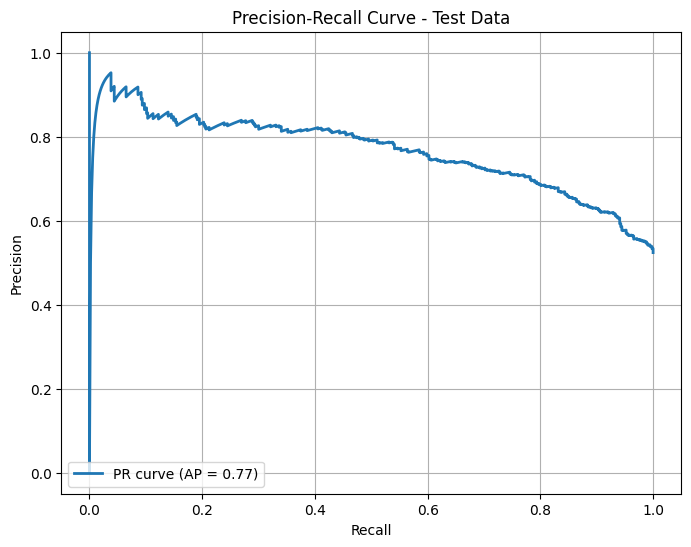

In [32]:
main()